In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
class PINNNet(nn.Module):
    """Feedforward Neural Network used inside the PINN."""

    def __init__(self):
        super(PINNNet, self).__init__()

        # Define network layers
        self.hidden1 = nn.Linear(1, 20)
        self.hidden2 = nn.Linear(20, 30)
        self.hidden3 = nn.Linear(30, 50)
        self.hidden4 = nn.Linear(50, 25)
        self.hidden5 = nn.Linear(25, 20)
        self.output = nn.Linear(20, 1)

        # Activation function
        self.activation = torch.tanh

        # Xavier initialization (helps with convergence)
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        """Forward pass through the network."""
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.activation(self.hidden4(x))
        x = self.activation(self.hidden5(x))
        return self.output(x)

In [3]:
class PINN:
    """
    Physics-Informed Neural Network (PINN)

    This class integrates physics-based constraints into the learning process
    to solve differential equations without relying on explicit labeled data.
    """

    def __init__(self, lb, ub, x0, u0, u00):
        """
        Initialize the PINN with domain bounds and initial conditions.

        Args:
            lb (float): Lower bound of the x-domain.
            ub (float): Upper bound of the x-domain.
            x0 (float): Initial position (usually boundary point).
            u0 (float): Function value at x0 (u(x0)).
            u00 (float): Derivative value at x0 (u'(x0)).
        """
        self.lb = float(lb)
        self.ub = float(ub)

        # Weight for boundary/initial condition loss
        self.lambda_ic = 100.0

        # Convert conditions to tensors
        self.x0 = torch.tensor([[float(x0)]], requires_grad=True)
        self.u0 = torch.tensor([[float(u0)]])
        self.u00 = torch.tensor([[float(u00)]])

        # Neural network and optimizer setup
        self.net = PINNNet()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2000, gamma=0.5)
        self.loss_fn = nn.MSELoss()
        
    def f_residual(self, x):
        """
        Compute the residual of the governing PDE:
            f(x) = u_xx + u = 0
        """
        x.requires_grad = True
        u = self.net(x)

        # Compute first and second derivatives
        u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        return u_xx + u

    def compute_loss(self, x_f):
        """
        Compute total loss combining:
            1. Physics residual loss (from PDE)
            2. Initial condition losses (u(x0), u'(x0))
        """
        # PDE residual loss
        f_out = self.f_residual(x_f)
        loss_f = self.loss_fn(f_out, torch.zeros_like(f_out))

        # Boundary/initial condition losses
        u0_pred = self.net(self.x0)
        loss_ic1 = self.loss_fn(u0_pred, self.u0)

        u0_x = autograd.grad(u0_pred, self.x0, torch.ones_like(u0_pred), create_graph=True)[0]
        loss_ic2 = self.loss_fn(u0_x, self.u00)

        # Weighted total loss
        total_loss = loss_f + self.lambda_ic * (loss_ic1 + loss_ic2)

        loss_dict = {
            "total": total_loss.item(),
            "physics": loss_f.item(),
            "initial_cond": (loss_ic1 + loss_ic2).item()
        }
        return total_loss, loss_dict

    def train(self, epochs=8000):
        """Train the PINN model over a specified number of epochs."""
        self.net.train()

        for epoch in range(epochs):
            self.optimizer.zero_grad()
            x_f = torch.linspace(self.lb, self.ub, 1000).reshape(-1, 1)
            loss, loss_dict = self.compute_loss(x_f)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            # Print progress periodically
            if epoch % 1000 == 0:
                print(f"Epoch {epoch:5d} | Total Loss: {loss_dict['total']:.6f} "
                      f"| Physics: {loss_dict['physics']:.6f} "
                      f"| IC: {loss_dict['initial_cond']:.6f}")


    def predict(self, x_test):
        """
        Predict u(x) for given input values within the training domain.

        Raises:
            ValueError: If x_test lies outside [lb, ub].
        """
        x_test_np = np.array(x_test)
        if np.any(x_test_np < self.lb) or np.any(x_test_np > self.ub):
            raise ValueError(f"Input values must be within the trained range [{self.lb}, {self.ub}].")

        self.net.eval()
        x_test_tensor = torch.tensor(x_test_np, dtype=torch.float32)
        with torch.no_grad():
            return self.net(x_test_tensor).numpy()


In [11]:
l, u = 0.0, 2 * np.pi
x_0, f_x, f_xx = 0.0, 0.0, 2.0

# Initialize and train the PINN
model_a = PINN(lb=l, ub=u, x0=x_0, u0=f_x, u00=f_xx)
model_a.train(epochs=5000)

Epoch     0 | Total Loss: 306.805908 | Physics: 0.066964 | IC: 3.067389
Epoch  1000 | Total Loss: 0.286123 | Physics: 0.285856 | IC: 0.000003
Epoch  2000 | Total Loss: 0.241513 | Physics: 0.241321 | IC: 0.000002
Epoch  3000 | Total Loss: 0.208624 | Physics: 0.208455 | IC: 0.000002
Epoch  4000 | Total Loss: 0.086506 | Physics: 0.086259 | IC: 0.000002


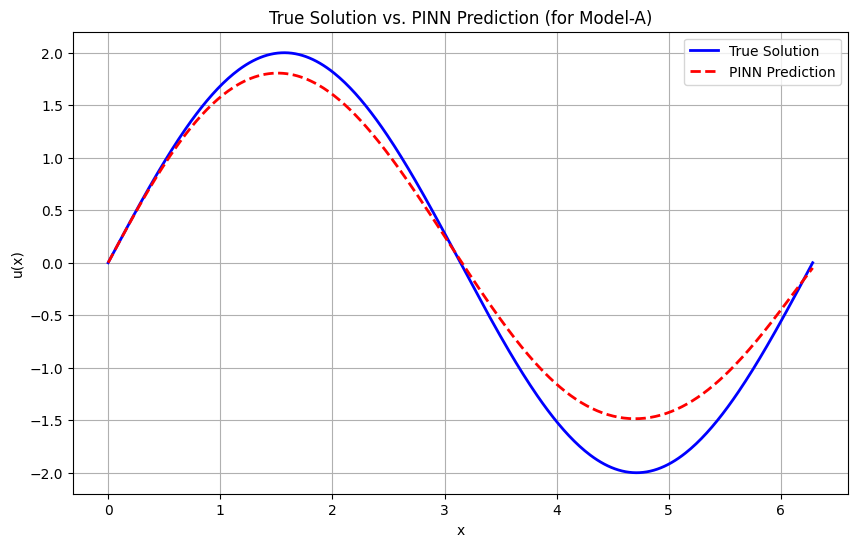

In [12]:
# Validation and comparison with analytical solution
# Dummy data
x_valid = np.linspace(l, u, 400).reshape(-1, 1)
u_true = f_x * np.cos(x_valid) + f_xx * np.sin(x_valid)
u_pred = model_a.predict(x_valid)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_valid, u_true, 'b-', linewidth=2, label="True Solution")
plt.plot(x_valid, u_pred, 'r--', linewidth=2, label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("True Solution vs. PINN Prediction (for Model-A)")
plt.grid(True)
plt.show()

In [17]:
model_b = PINN(lb=l, ub=u, x0=x_0, u0=f_x, u00=f_xx)
model_b.train(epochs=7500)

Epoch     0 | Total Loss: 554.913086 | Physics: 0.229042 | IC: 5.546840
Epoch  1000 | Total Loss: 0.300926 | Physics: 0.300602 | IC: 0.000003
Epoch  2000 | Total Loss: 0.251765 | Physics: 0.251576 | IC: 0.000002
Epoch  3000 | Total Loss: 0.240336 | Physics: 0.240167 | IC: 0.000002
Epoch  4000 | Total Loss: 0.225423 | Physics: 0.225332 | IC: 0.000001
Epoch  5000 | Total Loss: 0.210464 | Physics: 0.210322 | IC: 0.000001
Epoch  6000 | Total Loss: 0.131489 | Physics: 0.131376 | IC: 0.000001
Epoch  7000 | Total Loss: 0.038851 | Physics: 0.038560 | IC: 0.000003


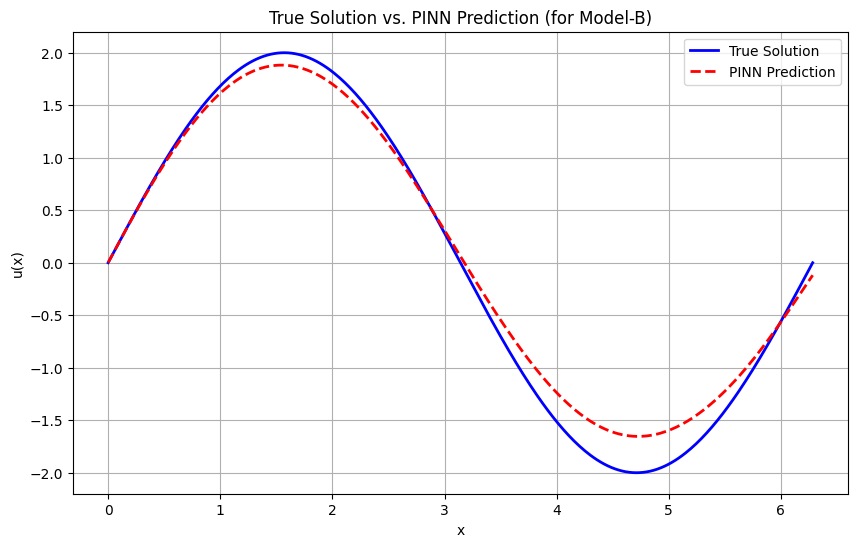

In [18]:
# Validation and comparison with analytical solution
# Dummy data
x_valid = np.linspace(l, u, 400).reshape(-1, 1)
u_true = f_x * np.cos(x_valid) + f_xx * np.sin(x_valid)
u_pred = model_b.predict(x_valid)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_valid, u_true, 'b-', linewidth=2, label="True Solution")
plt.plot(x_valid, u_pred, 'r--', linewidth=2, label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("True Solution vs. PINN Prediction (for Model-B)")
plt.grid(True)
plt.show()

In [15]:
model_c = PINN(lb=l, ub=u, x0=x_0, u0=f_x, u00=f_xx)
model_c.train(epochs=10000)

Epoch     0 | Total Loss: 354.817505 | Physics: 0.009120 | IC: 3.548084
Epoch  1000 | Total Loss: 0.283366 | Physics: 0.283115 | IC: 0.000003
Epoch  2000 | Total Loss: 0.251049 | Physics: 0.250865 | IC: 0.000002
Epoch  3000 | Total Loss: 0.243008 | Physics: 0.242835 | IC: 0.000002
Epoch  4000 | Total Loss: 0.226900 | Physics: 0.226739 | IC: 0.000002
Epoch  5000 | Total Loss: 0.203781 | Physics: 0.203636 | IC: 0.000001
Epoch  6000 | Total Loss: 0.129691 | Physics: 0.129282 | IC: 0.000004
Epoch  7000 | Total Loss: 0.044179 | Physics: 0.044115 | IC: 0.000001
Epoch  8000 | Total Loss: 0.007351 | Physics: 0.007348 | IC: 0.000000
Epoch  9000 | Total Loss: 0.003795 | Physics: 0.003794 | IC: 0.000000


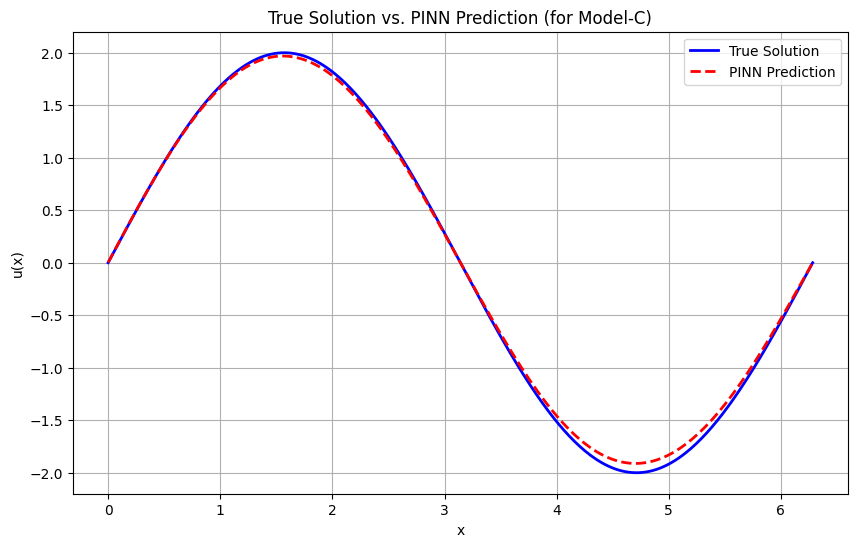

In [16]:
# Validation and comparison with analytical solution
# Dummy data
x_valid = np.linspace(l, u, 400).reshape(-1, 1)
u_true = f_x * np.cos(x_valid) + f_xx * np.sin(x_valid)
u_pred = model_c.predict(x_valid)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_valid, u_true, 'b-', linewidth=2, label="True Solution")
plt.plot(x_valid, u_pred, 'r--', linewidth=2, label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("True Solution vs. PINN Prediction (for Model-C)")
plt.grid(True)
plt.show()